# Prediction of e-scooter trip counts in the city of Malmo

In [2]:
# Imports
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV #, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

## Preparing dataset

- The training dataset contains independent features and a dependent feature, which is the number of outgoing trips from each h3 zone. However, some areas of the city lack infrastructure and drop-off points, so it would be more appropriate to use data for training models of areas that have such infrastructure.

In [3]:
# Read features file
data_set_new = gpd.read_parquet('Data/features_dataset.parquet').sort_index()

# Select only objects with targets_intersects == True
data_set_new = data_set_new.query("targets_intersects == True")
# Create features and target datasets 
features = data_set_new.drop(columns=['outgoing_trips','kommunnamn','regsokod','regso','geometry','targets_intersects'])
target = data_set_new[['outgoing_trips']]

In [4]:
# Sorting features columns
features = features[sorted(features.columns)]
features.columns

Index(['f0', 'f01', 'f03', 'f04', 'f05', 'f07', 'f08', 'f12', 'f13', 'f14',
       'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f25', 'f26',
       'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36',
       'f37', 'f38'],
      dtype='object')

In [61]:
# Split datasets to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=41, test_size=0.25, shuffle=True)

In [62]:
# Get indexes of targets for future use
y_test_ind = y_test.index
y_train_ind = y_train.index

# Reshape the subsets
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)


In [63]:
# Explore the targets of test subset
y_test.describe().to_frame()

,outgoing_trips
count,210.00000
mean,7.72619
std,20.04785
min,0.00000
25%,0.00000
50%,0.00000
75%,4.50000
max,175.50000


In [64]:
# Explore the targets of train subset
y_train.describe().to_frame()

,outgoing_trips
count,630.000000
mean,8.888095
std,22.800105
min,0.000000
25%,0.000000
50%,0.000000
75%,6.000000
max,256.500000


## Error measures

- The main metrics for comparing the quality of two different models will be sMAPE (Symmetric mean absolute percentage error) and RMSE (Root mean squared error).


Oddly, there are two definitions of sMAPE according to [**Wikipedia**](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error).


Additionally, there are other definitions of sMAPE found in [**research**](https://onlinelibrary.wiley.com/doi/10.1111/gean.12354).

- More information about sMAPE interpretation can be found in this [article](https://medium.com/@davide.sarra/how-to-interpret-smape-just-like-mape-bf799ba03bdc).

In [65]:
# Create function for calculating sMAPE 0-200


def smape_200(actual, predicted):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between actual and predicted values.

    """
    
    return np.mean(np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))/2))* 100

In [66]:
# Create function for calculating sMAPE 0-100


def smape_100(actual, predicted):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between actual and predicted values.

    """
    
    return np.mean(np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))* 100

In [67]:
# Create function for calculating sMAPE 


def smape_res(actual, predicted):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between actual and predicted values.
    FROM research

    """
    
    return np.mean(np.abs(actual - predicted) / (actual + predicted + 1))

## Random Forest Regression

In [68]:
# Define the parameter grid for the Random Forest Regressor
param_grid = {'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,20,21],
              'max_depth': [6, 7, 8, 9]}

In [69]:
# Create a RandomForestRegressor 
rf = RandomForestRegressor(random_state=41, criterion='squared_error') # criterion=“squared_error”, “absolute_error”, “friedman_mse”, “poisson”

# Create a GridSearchCV 
rf_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV 
rf_search.fit(X_train, y_train)

# Print the best sMAPE score
print("The best MSE value for the Random Forest is {:.3f} with the following hyperparameter values: {}"
      .format(-rf_search.best_score_, rf_search.best_params_))

# Get the best estimator
best_rf = rf_search.best_estimator_

# Make predictions on the test data (X_test)
y_pred = best_rf.predict(X_test)

The best MSE value for the Random Forest is 158.690 with the following hyperparameter values: {'max_depth': 9, 'n_estimators': 15}


- Metrics of quality for test subset

In [70]:
# Print various evaluation metrics for the model's predictions

print(f"MSE: {mean_squared_error(y_test, y_pred)}")  # Mean Squared Error
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")  # Root Mean Squared Error
print()
print(f"SMAPE 0-200: {smape_200(y_test, y_pred)}")     # Symmetric Mean Absolute Percentage Error 0-200
print(f"SMAPE 0-100: {smape_100(y_test, y_pred)}")     # Symmetric Mean Absolute Percentage Error 0-100
print(f"SMAPE RESEARCH: {smape_res(y_test, y_pred)}")  # Custom SMAPE variant (research specific)
print()
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")  # Mean Absolute Error
print(f"R2: {r2_score(y_test, y_pred)}")              # R-squared

MSE: 73.55821812355244
RMSE: 8.576608777573595

SMAPE 0-200: 133.97823611514812
SMAPE 0-100: 66.98911805757406
SMAPE RESEARCH: 0.2714714214469991

MAE: 4.00706209023915
R2: 0.8161055623319353


In [71]:
# Save whe best estimator
joblib.dump(best_rf, 'RandomForestRegressor_Malmo.pkl')

['RandomForestRegressor_Malmo.pkl']

In [72]:
# Create the predictions DataFrame and set the index
predictions = pd.DataFrame({'h3_polyfill': y_test_ind, 'pred': y_pred}).set_index('h3_polyfill', drop=True)

# Select the desired columns from the data_set_new DataFrame
head = data_set_new[['kommunnamn', 'regsokod', 'regso', 'geometry', 'targets_intersects', 'outgoing_trips']]

# Join the predictions DataFrame with the head DataFrame
head = head.join(predictions)

# Filter rows where the 'pred' column is not NaN
head = head.dropna(subset=['pred'])

# Calculate the 'delta' column
head["delta"] = head.pred - head.outgoing_trips

# Describe the 'delta' column
delta_description = head.delta.describe()

print(delta_description)

count    210.000000
mean       1.156516
std        8.518582
min      -52.233333
25%        0.030379
50%        0.108301
75%        2.000572
max       50.933333
Name: delta, dtype: float64


- The differences between the predicted values by the Random Forest Regression and the observed values in the test data set are shown. 

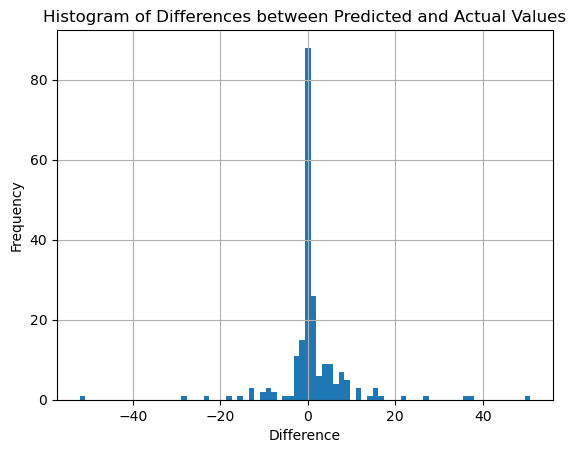

In [73]:
# Hist for differences between the predicted and actual values
head.delta.hist(bins=80)
plt.title('Histogram of Differences between Predicted and Actual Values')
plt.xlabel('Difference')
plt.ylabel('Frequency');

## LightGBM Regression

In [74]:
# Define the parameter grid for the LGBMRegressor
param_grid_lgbm = {'n_estimators': range(600, 1200, 100),
              'num_leaves': [3,6,9,12],
             'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1]
                  }

In [75]:
# Create a LGBMRegressor

lgbm = LGBMRegressor(random_state=41)

# Create a GridSearchCV 
lgbm_search = GridSearchCV(lgbm, param_grid_lgbm, cv=5, scoring="neg_mean_squared_error")
lgbm_search.fit(X_train, y_train)

# Fit the GridSearchCV 
lgbm_search.fit(X_train, y_train)

# Print the best sMAPE score
print("The best MSE value for the Random Forest is {:.3f} with the following hyperparameter values: {}"
      .format(-lgbm_search.best_score_, lgbm_search.best_params_))

# Get the best estimator
best_lgbm = lgbm_search.best_estimator_

# Make predictions on the test data (X_test)
y_pred = best_lgbm.predict(X_test)

The best MSE value for the Random Forest is 165.338 with the following hyperparameter values: {'learning_rate': 0.005, 'n_estimators': 800, 'num_leaves': 9}


- Metrics of quality for test subset

In [76]:
# Print various evaluation metrics for the model's predictions
print(f"MSE: {mean_squared_error(y_test, y_pred)}")  # Mean Squared Error
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")  # Root Mean Squared Error
print()
print(f"SMAPE 0-200: {smape_200(y_test, y_pred)}")     # Symmetric Mean Absolute Percentage Error 0-200
print(f"SMAPE 0-100: {smape_100(y_test, y_pred)}")     # Symmetric Mean Absolute Percentage Error 0-100
print(f"SMAPE RESEARCH: {smape_res(y_test, y_pred)}")  # Custom SMAPE variant (research specific)
print()
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")  # Mean Absolute Error
print(f"R2: {r2_score(y_test, y_pred)}")              # R-squared

MSE: 91.90172638108793
RMSE: 9.586538811327472

SMAPE 0-200: 134.12924467177544
SMAPE 0-100: 67.06462233588772
SMAPE RESEARCH: 0.27420812607858513

MAE: 4.067086783851293
R2: 0.7702470679049352


In [77]:
# Save whe best estimator
joblib.dump(best_lgbm, 'LGBMRegressor_Malmo.pkl')

['LGBMRegressor_Malmo.pkl']

In [79]:
# Create the predictions DataFrame and set the index
predictions = pd.DataFrame({'h3_polyfill': y_test_ind, 'pred': y_pred}).set_index('h3_polyfill', drop=True)

# Select the desired columns from the data_set_new DataFrame
head = data_set_new[['kommunnamn', 'regsokod', 'regso', 'geometry', 'targets_intersects', 'outgoing_trips']]

# Join the predictions DataFrame with the head DataFrame
head = head.join(predictions)

# Filter rows where the 'pred' column is not NaN
head = head.dropna(subset=['pred'])

# Calculate the 'delta' column
head["delta"] = head.pred - head.outgoing_trips

# Describe the 'delta' column
delta_description = head.delta.describe()

print(delta_description)

count    210.000000
mean       0.576604
std        9.592048
min      -88.181316
25%       -0.281646
50%        0.313378
75%        1.410271
max       42.718620
Name: delta, dtype: float64


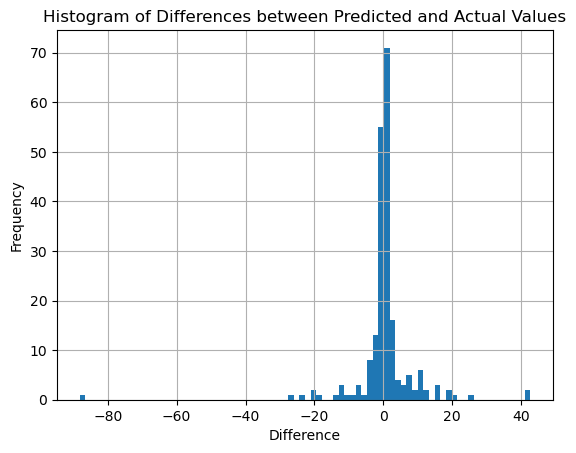

In [80]:
# Hist for differences between the predicted and actual values
head.delta.hist(bins=80)
plt.title('Histogram of Differences between Predicted and Actual Values')
plt.xlabel('Difference')
plt.ylabel('Frequency');

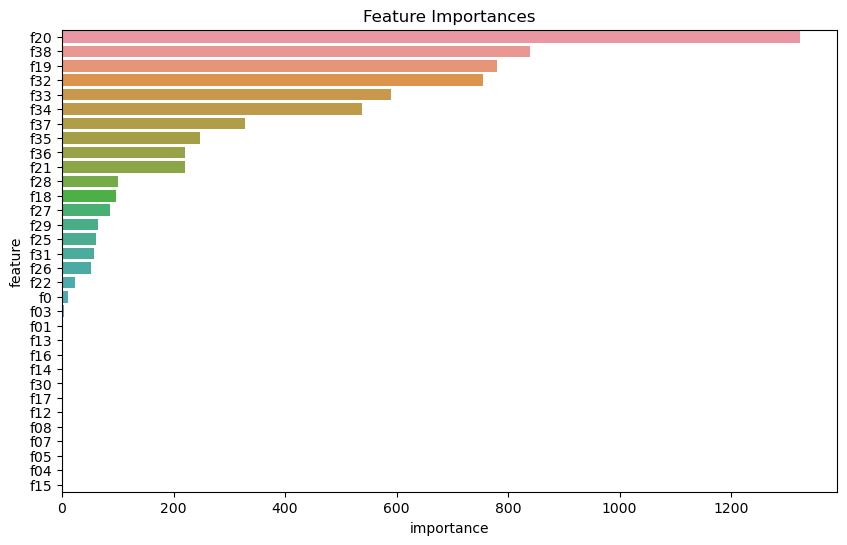

In [81]:
# Extract the feature importances and create a DataFrame
feature_importances = best_lgbm.feature_importances_
feature_names = best_lgbm.feature_name_
imp = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importances}
).sort_values(by="importance", ascending=False)

# Barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=imp, ax=ax)
plt.title("Feature Importances")
plt.show()

## Metrics of baseline models

In [84]:
# MEAN model

y_pred = np.full_like(y_test, np.mean(target, axis=0))

# Print various evaluation metrics for the model's predictions

print(f"MSE: {mean_squared_error(y_test, y_pred)}")  # Mean Squared Error
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")  # Root Mean Squared Error
print()
print(f"SMAPE 0-200: {smape_200(y_test, y_pred)}")     # Symmetric Mean Absolute Percentage Error 0-200
print(f"SMAPE 0-100: {smape_100(y_test, y_pred)}")     # Symmetric Mean Absolute Percentage Error 0-100
print(f"SMAPE RESEARCH: {smape_res(y_test, y_pred)}")  # Custom SMAPE variant (research specific)
print()
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")  # Mean Absolute Error
print(f"R2: {r2_score(y_test, y_pred)}")              # R-squared

MSE: 400.7617970521542
RMSE: 20.019035867197854

SMAPE 0-200: 151.75071481612378
SMAPE 0-100: 75.87535740806189
SMAPE RESEARCH: 0.6895880893715745

MAE: 11.297074829931972
R2: -0.0018984579528820156


In [85]:
# MEDIAN model
y_pred = np.full_like(y_test, np.median(target))

# Print various evaluation metrics for the model's predictions
print(f"MSE: {mean_squared_error(y_test, y_pred)}")  # Mean Squared Error
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")  # Root Mean Squared Error
print()
print(f"SMAPE 0-200: {smape_200(y_test, y_pred)}")     # Symmetric Mean Absolute Percentage Error 0-200
print(f"SMAPE 0-100: {smape_100(y_test, y_pred)}")     # Symmetric Mean Absolute Percentage Error 0-100
print(f"SMAPE RESEARCH: {smape_res(y_test, y_pred)}")  # Custom SMAPE variant (research specific)
print()
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")  # Mean Absolute Error
print(f"R2: {r2_score(y_test, y_pred)}")              # R-squared

MSE: 459.69642857142856
RMSE: 21.440532376119503

SMAPE 0-200: 200.0
SMAPE 0-100: 100.0
SMAPE RESEARCH: 0.38222283543925606

MAE: 7.726190476190476
R2: -0.14923414931245094
